In [2]:
import math
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, execute
from qiskit.visualization import plot_histogram, circuit_drawer
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import CU1Gate, QFT
from math import gcd
from fractions import Fraction

In [3]:
#helper functions
def make_permutation_matrix(n, permutation):
    r = np.zeros((n,n), dtype=int)
    for i in range(n):
        r[permutation(i), i] = 1
    return r

def mult_mat(x,k,N):
    n = math.ceil(math.log(N, 2))
    return make_permutation_matrix(
    2**n,
    permutation=lambda y:  y*pow(x,k) % N if y<N else y)

def c_mult_mat(x,k,N):
    n = math.ceil(math.log(N, 2))
    permutation = lambda y: y if y%2==0 or (y-1)/2 >= N else 2*(int((y-1)/2)*pow(x,k) % N) + 1
    return make_permutation_matrix(2*(2**n), permutation )

def mult_op(x,k,N):
    return Operator(mult_mat(x,k,N))

#controlled-U oracle 

def c_mult_op(x,k,N):
    return Operator(c_mult_mat(x,k,N))


# QFT and IQFT
def qft(circ, q, n):
    """n-qubit QFT on q in circ."""
    for j in range(n):
        circ.h(q[j])
        for k in range(j+1,n):
            circ.cu1(math.pi/float(2**(k-j)), q[k], q[j])
    for i in range(n//2):
        circ.swap(q[i], q[n-i-1])
        
def iqft(circ,q,n):
    for j in range(n):
        circ.h(q[j])
        for k in range(j+1,n):
            #circ.cu1(-math.pi/float(2**(k-j)), q[k], q[j])
             gate = CU1Gate(-np.pi/float(2**(k-j)) )
             circ.append(gate, [q[k],q[j]])
    for i in range(n//2):
        circ.swap(q[i], q[n-i-1])

## Circuit implementation

* Choose N and x

If you get r=1 you might need to rerun from here or choose a different x

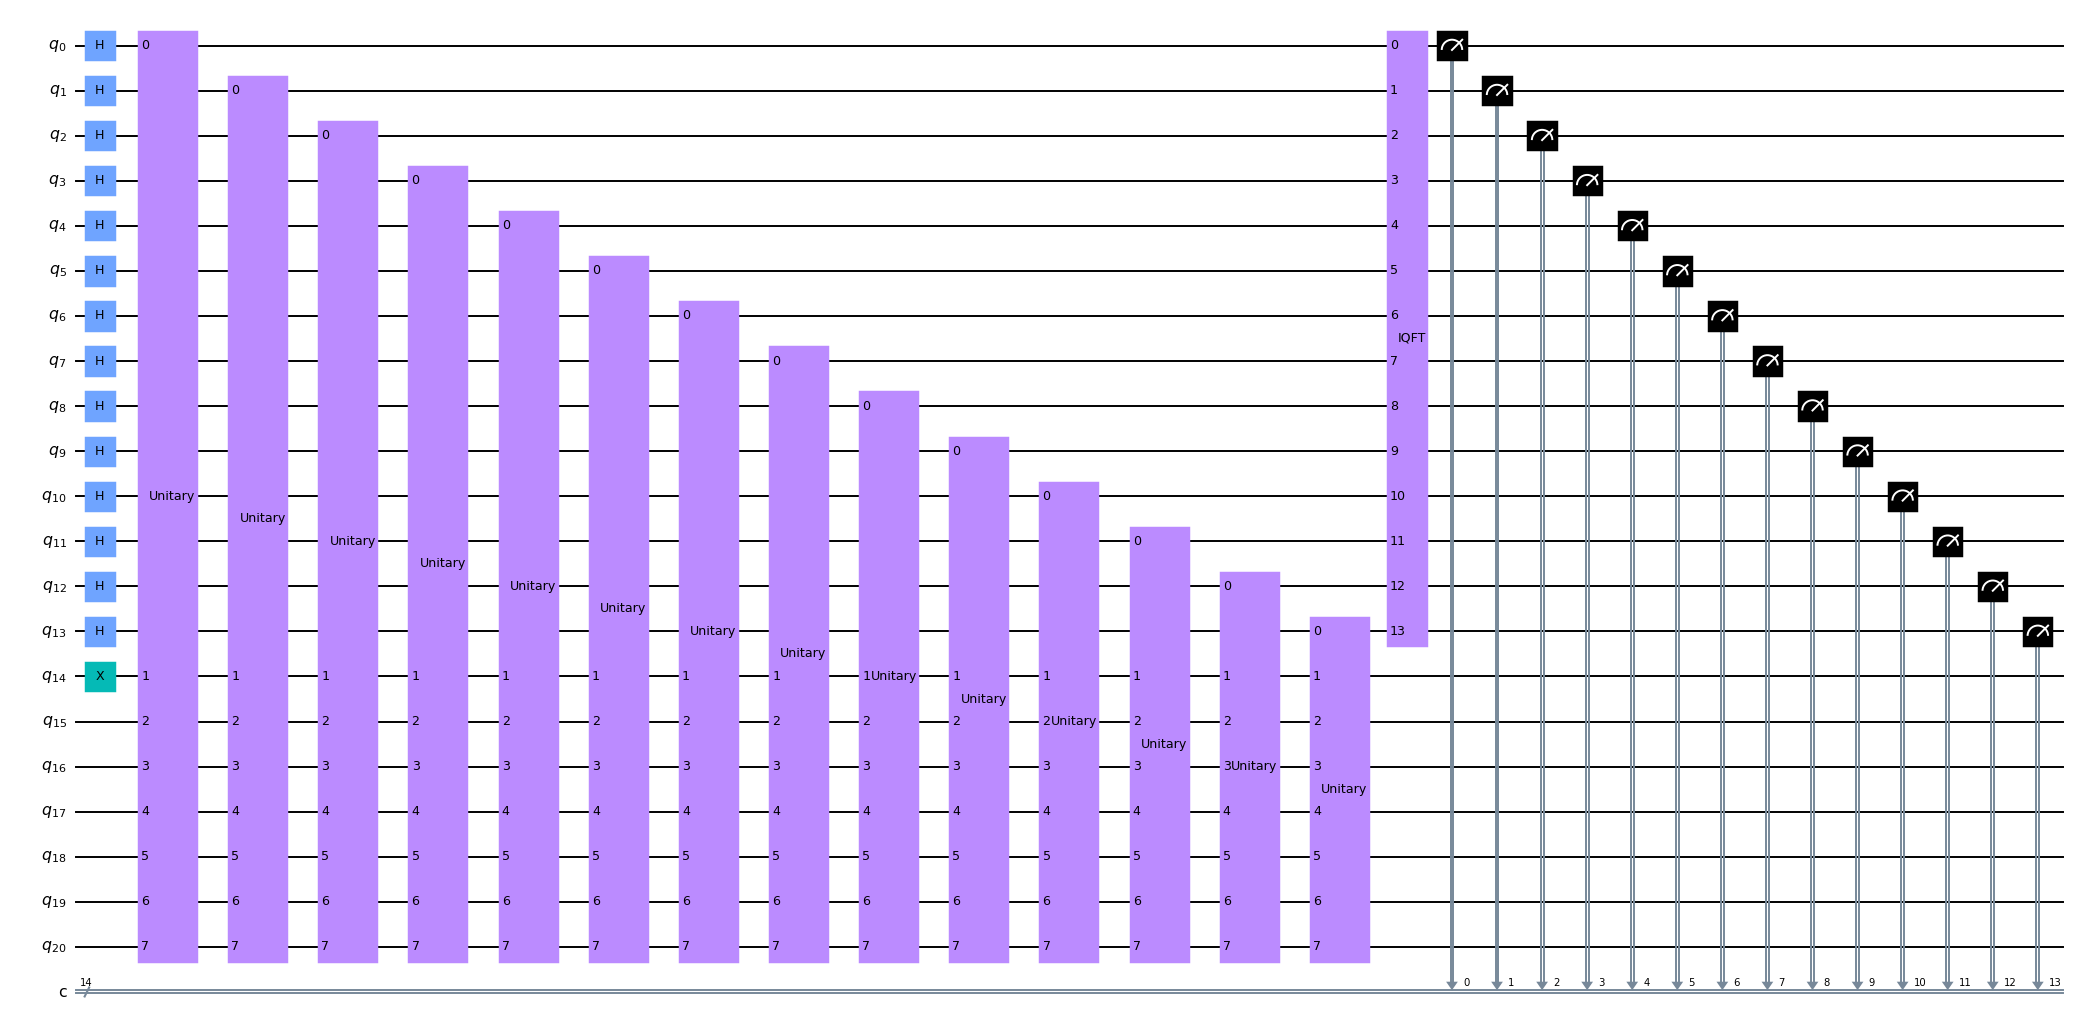

In [35]:
# Constants
N = 119
# N = 133
x = 9
n_count = 2 * math.ceil(math.log2(N))  # number of counting qubits
o_qbits = math.ceil(math.log2(N))  # oracle qubits

# Quantum Phase Estimation Circuit
qc = QuantumCircuit(n_count + o_qbits, n_count)

qc.x(n_count) # converting to |1> eigenstate
for q in range(n_count):
    qc.h(q)
for q in range(n_count):
    qc.unitary(c_mult_op(x,2**q,N), [q] + [i + n_count for i in range(o_qbits)]) # Adding Unitary operation

qft_circuit = QFT(n_count)
iqft_circuit = qft_circuit.inverse()  # Used inbuilt IQFT, provided IQFT wasn't working correctly for some reason
qc.append(iqft_circuit, range(n_count))

qc.measure(range(n_count), range(n_count))

# Visualize the Circuit
circuit_drawer(qc, output='mpl', scale=0.7, fold=-1)

## Simulation

The circuit works for N=77, 91, 119 (n_count=7) if we have large enough shots, but for 133 the simulation step takes a lot of time.
I couldn't really figure out any optimization techniques but I did find this research paper that proposes better circuit: https://arxiv.org/pdf/quant-ph/0205095.pdf

Below is histogram for a long run for N=133. This yielded r=9 but no factors found.
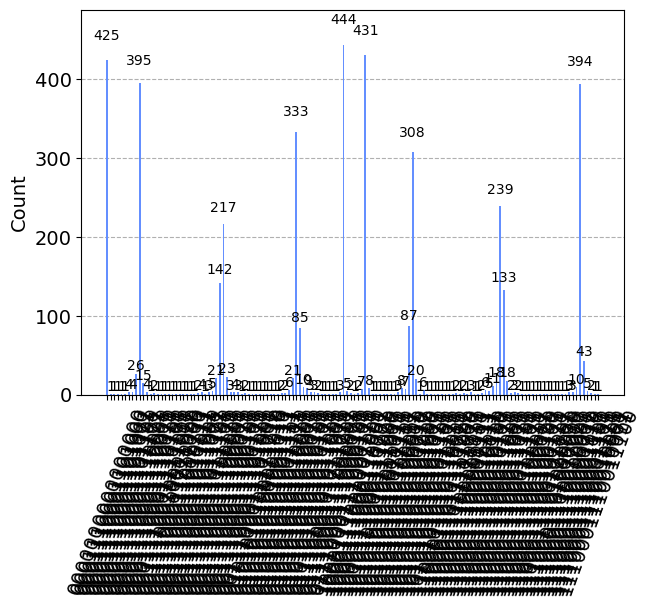

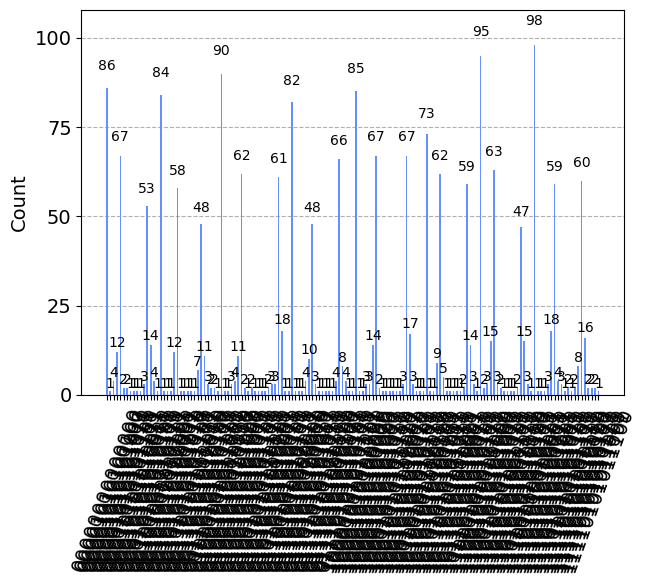

In [40]:
# Simulate the Circuit
simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, simulator)
result = simulator.run(transpiled_qc, shots=2*1024).result()
counts = result.get_counts(qc)

# Plot histogram
plot_histogram(counts)

Measured phases are in binary. Convert it to decimal and divide it by 2^n_count to get the fraction to find r. 

In [41]:
# Determine the order r
def determine_order(counts):
    measured_str = max(counts, key=counts.get)
    measured = int(measured_str, 2)    # converting binary to decimal
    phase = measured / (2**n_count)
    frac = Fraction(phase).limit_denominator(N)      # compute s/r for phase
    return frac.denominator

r = determine_order(counts)
print(f"Order r: {r}")

# Classical post-processing to factorize N
factor_found = False
if r % 2 == 0:
    plus = gcd(pow(x, r//2) + 1, N)
    minus = gcd(pow(x, r//2) - 1, N)
    if plus not in [1, N]:
        print(f"One factor of {N} is {plus}")
        factor_found = True
    if minus not in [1, N]:
        print(f"One factor of {N} is {minus}")
        factor_found = True

if not factor_found:
    print("No factors found. Try a different random x or run from circuit cell again.")

Order r: 8
One factor of 119 is 17
